# **Final Project - Adaptation to new classes using 2-step method**

Group Member: Chenchen Tang, Haojia Nie


This work explores the method using unsupervised to train classification network to detect K+N classes. Given K classes with labels, we use them to train a supervised convolutional neural network. Our goal for this step is to minimize the loss and produce relatively high accuracy for the detection of the K classes. Then we use the trained network and input it with (K+N) classes, which N classes unseen by the network. In this step, we exclude the top dense layers of the trained network and only collect the middle layer features produced by the network. Then we use those features to perform K-means clustering and the classification yield by the clustering would be our prediction result.

Besides from that, we've also tried a new way of preprocess the dataset. Instead of using the original image and and apply transformations. We create artificial sample image by randomly choose X images from the same class and combine them together. It helps the network to learn more features and yield a better accuracy for the K+N class detection. 

The main goal of the project is to produce a way of classification that is able to adapt to new classes. We have demonstrated that using the features of the trained network for clustering performs better than regular K-means using original images. It has been shown that it has the better capability for the classification of unseen classes.

## Team member and contributions

Working together

*  Search for related resources (paper & tutorial)
*  Talk about Central Ideas of project
*  Finish Part 3 (Mixing Image and Data Augmentation)
*  Finish Part 2a (Creating Network for fully supervised training)
*  Test & Debug the whole project
*  Talk about the Final Conclusion

Chenchen Tang
  

*   Finish first draft of project (Separate each section in assignment version & Offers some starter code)
*   Finish Part 1(a), 1(b) (Initialization and Dataset Preparation / Loading)
*   Finish Part 2(b) (Create Own Loss Function, Add Regularization)
*   Finish Part 3 (Fully Supervised Train Block & Evaluate Accuracy)
*   Finish Part 5(c) (Count clusters and separate them)
*   Finish Part 6 ”Manually assign label to cluster” method for evalution
*   Finish Part 6(a), 6(b) Generate code to summarize all evaluation

Haojia Nie


*   Finish Part 1(c) (Create original, diy, combine datasets)
*   Finish Part 5(a), 5(b) (Encoder & Decoder of the Unsupervised Section)
*   Finish Part 6 (Purity and Rand Index Evalution Methods)
*   Polish the code and reorganize the structure (Rewrite code in Classes & Methods format)
*   Write the Abstract and Add detailed explaination in the middle section.
*   Expand bullet point into Final Conclusion, and add Reference



## **Part 1: Initialization and Dataset Preparation**
In this part, we will do initializations of the whole project who includes the following steps

1.   Import the libraries will be used
2.   Image Preprocessing and Dataset Loading
3.   Mixing Image and Data Augmentation



#### **a. Import Code Libraries**

In this section, we will list out the libraries we use and the importance of using it 
  * time
     * This module provides the time-related functions and we use it to record the time an algorithm or a training takes.
  * numpy
      * This module provides the array processing functions and we use it for doing array and matrix manupilation.
  * matplotlib.pyplot
      * This module provides a way to visualize data and we use it to showcase the sample data, learning curve etc.
  * pandas
      * This module provides the streamlined form of data frame and we used it for doing data analysis and manipulation
  * torch
      * This module offers a way to create tensor and building network and we used it for building the classification neural network pipeline.
  * keras.datasets
      * keras.datasets provides a few datasets for machine learning and we used the Fashion MNIST datasets. 
  * torchvision
      * torchvision is a library that provides the computer vision features that can be used with pyTorch, and we use it for image transformation. 
  * sklearn
      * sklearn is a predictive data analysis tools that is compatible with numpy, scipy and matplotlib. We use it to analyse the data including evaluate the performance of clustering and etc.

  * itertools
      * This implies that the loss function need to be improved for better indication of model accuracy and the network itself may require some redesign.

In [ ]:
# Import python Libraries
import time

# Import essential libraries for data manipulations.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools

# Import libraries for network and k-means
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from keras.datasets import fashion_mnist
from keras import backend
from torchvision import datasets, utils, models
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import homogeneity_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split


#### **b. Image Preprocessing and Dataset Loading**

1. Image Preprocessing 

    We use several transform function to preprocess the training dataset including Random Crop, Padding, Random Horizontal Flip and Normalization. The reason we add the randomess in the image process (Flip and Crop) is to artificially augment the dataset so that each iteration the network will take a slightly different input. The reason behind cropping is to deal with the potential size difference between each images. Finally, we perform normalization to make the mean and std of each image to be 0 and 1 respectively.

2. Choose Dataset 

    We choose the Fashion MNIST dataset to do classification. The advantages of choosing Fashion MNIST over other dataset is because this dataset better models the real-world computer vision data. And at the same time, it is not as complicated as the real world data which makes it suitable for this group project. 

3. Data Loading

    We load the dataset using torch DataLoader.


In [ ]:
# Define Batch Size 
batch_size = 64

random.seed(0)
torch.manual_seed(0)

# Define the transformatino for train data
train_transform = transforms.Compose([# transforms.ToTensor(),
                    # should NOT use RandomResizeCrop too harshly, because this is not a
                    # segmentation problem, where each pixel in the output corresponds to the input
                    # transforms.RandomCrop(20), # multiple of num_cut
                    # transforms.Resize(28, interpolation=transforms.InterpolationMode.NEAREST),
                    # transforms.Pad(4),
                    transforms.RandomHorizontalFlip(),
                    transforms.Normalize((0.5,), (0.5,))])

# Define the transformation for test data 
test_transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                  download=True,
                  train=True)
trainloader = DataLoader(trainset,
                      batch_size=batch_size,
                      shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', 
                  download=True,
                  train=False,
                  transform=test_transform)
testloader = DataLoader(testset,
                      batch_size=batch_size,
                      shuffle=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



#### **c. Mixing Image and Data Augmentation**



#####**Methodology**
This part is to create our training dataset by combine the original image and mixing normal images which we will explain later.

Here we propose a way of creating a single sample image by randomly choose k images from the same class and combine them togher. For example, if we crop it 2 times, one from the center of horizontal line and another from the center of the vertical line. The combined image will be assembled by the cropped pieces of 4 images as shown below.

<pre>
------------------------
            |
   img1     |  img2 
            |
------------------------ 
            |
   img3     |  img4
            |
------------------------ 
</pre>



#####**Implementation Details**

First, we implement reconstruct function that randomly choose n images from the same class in dataset. Then it crops each image and combine together and create the mixed image. We named this dataset train_X_diy, train_y_diy. 

Then, to create the training set, we concatenate the original dataset with the mixed image dataset and get train_X_comb and train_y_comb. This is the preprocess of the dataset.

After that, we seperated the dataset(train_X_comb, train_y_comb) into two sets. The first training set has K classes (train_lX_comb, train_ly_comb). We will be using this set for the fully supervised network. Another set has N classes (train_uX_comb, train_uy_comb) and we will be erase their labels. This dataset will be used in the unsupervised classification. 


Also we create (trainX_flatten) for the comparison test in later section 




In [ ]:
# Define K,  N and classes
classes = list(trainset.class_to_idx.keys())
K = 7
N = len(classes) - K

In [ ]:
# Define reconstruct marix

def reconstruct(img, target, num_cut, num_dup, num_classes):

  # initialize rescontrstuct image, target
  reconstruct_img = []
  reconstruct_target = []

  # Calculate the width and height we need to cut
  cut_width = img.size()[1] // num_cut
  cut_height = img.size()[2] // num_cut

  # define random matrix 
  rand_matrix = np.random.randint(0, img.size()[0] // num_classes, size=(num_dup,num_cut,num_cut))

  # create the reconstrcted image, target
  for label in range(num_classes):
    img_pool = img[target == label]
    for count in range(num_dup):
      new_img = np.zeros((img.size()[1], img.size()[2]))

      # assign each part with a random image section in the same class
      for i in range(num_cut):
        for j in range(num_cut):
          i1, i2 = i*cut_width, (i+1)*cut_width
          j1, j2 = j*cut_height, (j+1)*cut_height
          img_idx = rand_matrix[count,i,j]
          new_img[i1:i2,j1:j2] = img_pool[img_idx,i1:i2,j1:j2]
        
      # append the reconstructed image to the list
      reconstruct_img.append(list(new_img))
      reconstruct_target.append(label)
    print(label)
  return torch.FloatTensor(reconstruct_img), torch.LongTensor(reconstruct_target)


In [ ]:
# Get the training data where X stands for the object and y stands for the target
train_X = trainset.data.type(torch.FloatTensor)
train_y = trainset.targets

test_X = testset.data.type(torch.FloatTensor)
test_y = testset.targets

# Method 0: Obtain the original data set train_x and train_y
train_X_orig = train_X.clone().detach()
train_y_orig = train_y.clone().detach()
train_X_orig = train_transform(train_X_orig)
trainset_orig = TensorDataset(train_X_orig, train_y_orig)
trainloader_orig = DataLoader(trainset_orig, batch_size=batch_size, shuffle=True)

# Method 1: Obtain the reconstructed train_x and train_y 
train_X_diy, train_y_diy = reconstruct(train_X, train_y, num_cut=2, num_dup=6000, num_classes=len(classes))
train_X_diy = train_transform(train_X_diy)
trainset_diy = TensorDataset(train_X_diy, train_y_diy)
trainloader_diy = DataLoader(trainset_diy, batch_size=batch_size, shuffle=True)

# Method 2: Obtain the combined data set of the original and reconstructed
train_X_comb = torch.cat((train_X_orig, train_X_diy))
train_y_comb = torch.cat((train_y_orig, train_y_diy))
trainset_comb = torch.utils.data.ConcatDataset([trainset_orig, trainset_diy])
trainloader_comb = DataLoader(trainset_comb, batch_size=batch_size, shuffle=True)

0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
print(train_X_orig.size())
print(train_X_diy.size())
print(train_X_comb.size())

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([120000, 28, 28])


In [ ]:
# To Filter the K classes we want from the dataset x
K = 7
arr = random.sample(range(0, 10), K)
print("random chosen index: ", arr)
def filter_K_class(x, chosen = arr):
  if x in arr:
    return True
  return False

# Obtain the filtered K Classes
def label_train_set(data_X, label_Y):
  train_x = data_X.clone().detach()
  train_y = label_Y.clone().detach()
  idx = np.array([filter_K_class(y) for y in train_y])
  train_x = train_x[idx].type(torch.FloatTensor)
  train_y = train_y[idx]
  trainset = TensorDataset(train_x, train_y)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  return trainset, trainloader, train_x, train_y

# Obtain the unlabled N classes
def unlabel_train_set(data_X, label_Y):
  train_X = data_X.clone().detach()
  train_y = label_Y.clone().detach()
  idx = np.array([filter_K_class(y) for y in train_y])
  train_X = train_X[~idx].type(torch.FloatTensor)
  train_y = train_y[~idx]
  trainset = TensorDataset(train_X, train_y)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  return trainset, trainloader, train_X, train_y

# labeled training set
trainset_l_orig, trainloader_l_orig, train_lX_orig, train_ly_orig = label_train_set(train_X_orig, train_y_orig)
trainset_l_diy, trainloader_l_diy, train_lX_diy, train_ly_diy = label_train_set(train_X_diy, train_y_diy)
trainset_l_comb, trainloader_l_comb, train_lX_comb, train_ly_comb = label_train_set(train_X_comb, train_y_comb)

# unlabled training_set
trainset_ul_orig, trainloader_ul_orig, train_uX_orig, train_uy_orig = unlabel_train_set(train_X_orig, train_y_orig)
trainset_ul_diy, trainloader_ul_diy, train_uX_diy, train_uy_diy = unlabel_train_set(train_X_diy, train_y_diy)
trainset_ul_comb, trainloader_ul_comb, train_uX_comb, train_uy_comb = unlabel_train_set(train_X_comb, train_y_comb)

testset_l, testloader_l, testset_lX, testset_ly = label_train_set(test_X, test_y)


random chosen index:  [0, 1, 2, 3, 4, 5, 7]


In [ ]:
# Here print the size, type, label type for trainLoader_original
for images, labels in trainloader_orig:
  print(images.size(), images.type(), labels.type())
  break

for images, labels in trainloader_l_orig:
  print(images.size(), images.type(), labels.type())
  break


# original total dataset size
trainX_flatten = torch.flatten(train_X_orig, 1).type(torch.FloatTensor)
print(trainX_flatten.shape, trainX_flatten.type())

# the labeled K dataset size
trainlX_flatten = torch.flatten(train_lX_orig, 1).type(torch.FloatTensor)
print(trainlX_flatten.shape, trainlX_flatten.type())

# the unlabeled N dataset size
trainX2_flatten = torch.flatten(train_uX_orig, 1).type(torch.FloatTensor)
print(trainX2_flatten.shape, trainX2_flatten.type())

torch.Size([64, 28, 28]) torch.FloatTensor torch.LongTensor
torch.Size([64, 28, 28]) torch.FloatTensor torch.LongTensor
torch.Size([60000, 784]) torch.FloatTensor
torch.Size([42000, 784]) torch.FloatTensor
torch.Size([18000, 784]) torch.FloatTensor


(b). The following cell shows some sample image in dataset.


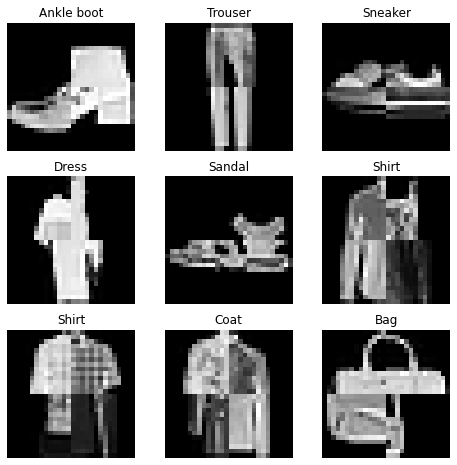

In [ ]:
# Display the sample images we have preprocessed
def show_sample_img(trainset):
	figure = plt.figure(figsize=(8, 8))
	cols, rows = 3, 3
	for i in range(1, cols * rows + 1):
		sample_idx = torch.randint(len(trainset), size=(1,)).item()
		img, label = trainset[sample_idx]
		figure.add_subplot(rows, cols, i)
		plt.title(classes[label])
		plt.axis("off")
		plt.imshow(img.squeeze(), cmap="gray")
	plt.show()

show_sample_img(trainset_diy)

## **Part 2: Implement network for fully supervised training**
In this part, we implemented the first step of the two-step method which is a supervised network (TRAINED_NET). We train the network by inputting images from K classes.


### **(a). Build the Network**

In [ ]:
# Define the Network 
class Net(nn.Module):
  def __init__(self, num_classes=len(classes), criterion=None):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.conv3 = nn.Conv2d(64, 4, 3, 1)
    self.dropout = nn.Dropout(0.1)
    self.fc1 = nn.Linear(1936, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x, include_top=True):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.dropout(x)
    if include_top:
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
    else:
      x = torch.flatten(x, 1)
    return x


### **(b). Define Loss Function**

In [ ]:
class MyCrossEntropyLoss(nn.Module):

  use_custom = False

  def __init__(self, params, lam):
    super(MyCrossEntropyLoss, self).__init__()
    self.params = params
    self.lam = lam

  def softmax(self, logits):
    if self.use_custom:
      exp_x = torch.exp(logits - torch.max(logits, 1, keepdim=True)[0])
      exp_x_sum = torch.sum(exp_x, 1, keepdim=True)
      x = torch.log(exp_x / exp_x_sum)
    else:
      x = F.log_softmax(logits, -1)
    return x

  def to_onehot(self, targets, num_classes):
    if self.use_custom:
      ones = torch.sparse.torch.eye(num_classes)
      y = ones.index_select(0, targets.cpu()).to(device)
    else:
      y = F.one_hot(targets, num_classes=num_classes)
    return y
 
  def forward(self, logits, targets):
    x = self.softmax(logits)
    y = self.to_onehot(targets, logits.size()[1])
    loss = - torch.sum(x * y) / logits.size()[0]
    reg = 0
    for p in self.params:
      reg += p.abs().sum()
    loss += self.lam * reg
    return loss

## **Part 3: Fully supervised training**
In this part, we will build the network (TRAINED_NET) and trained to classify K classes. Our idea is that we use the images from the K classes for training the network and tunning its parameters. If the network has lower loss value that means it has better capability of differentiating the K classe. Then, in the later K-means classification, the features we use will better differentiate those K class from the N classes and may produce more accurate classification.

**Note**

In our network, we add in an important parameter called include_top. This parameter seperates the fully connected layers and the layers before it. If we set the include_top to be True, we will obtain the features created by the nerual network instead of the final classification label. For now, we set the default value of include_top to be True, later we will set it to False for the use of unsupervised classification. 



In [ ]:
# Define use of GPU or CPU
USE_GPU = False
device = 'cpu'
if USE_GPU:
  device = 'cuda'

In [ ]:
# We use Cross Entropy Loss as loss function and Adam as Optimizer
model = Net().to(device)
criterion = MyCrossEntropyLoss(model.parameters(), 0.1)
optimizer = torch.optim.Adam(model.parameters())
untrained_model = Net().to(device)

**Epoch**

In [ ]:
epoch = 12

def get_loss(model, trainloader, testloader, epoch):
  index = 0
  train_loss = []
  test_loss = []
  test_accu = []
  while True:
    run_loss = 0
    model.train()
    for images, labels in trainloader:

      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      output = model(images[:,None,:,:])
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      run_loss += loss.item()

    training_loss = run_loss/len(trainloader)
    train_loss.append(training_loss)
    print("Epoch: {:2}, Train Loss:  {:1.3}".format(index, training_loss),end=", ")

    run_loss2 = 0
    accu_num = 0
    sum_num = 0
    model.eval()
    with torch.no_grad():
      for images, labels in testloader:
        
        images, labels = images.to(device), labels.to(device)
        output = model(images[:,None,:,:])
        # loss2 = criterion(output, labels)
        # run_loss2 += loss2.item()

        ps = torch.exp(output)
        arr = []
        with torch.no_grad():
          arr = np.argmax(ps.cpu().numpy(), axis=1)
        accu_num += np.sum(labels.cpu().numpy() == arr)
        sum_num += 64

      accu_rate = accu_num/sum_num
      test_accu.append(accu_rate)
      print("Accuracy: ", accu_rate)

    index += 1
    if index >= epoch:
      return train_loss, test_accu

# use the labeled (seen) classes in trainset
loss_list, test_accu = get_loss(model, trainloader_l_comb, testloader_l, epoch)

Epoch:  0, Train Loss:  0.518, Accuracy:  0.8926136363636363
Epoch:  1, Train Loss:  0.141, Accuracy:  0.9123579545454545
Epoch:  2, Train Loss:  0.115, Accuracy:  0.9129261363636364
Epoch:  3, Train Loss:  0.102, Accuracy:  0.9161931818181818
Epoch:  4, Train Loss:  0.0889, Accuracy:  0.9196022727272727
Epoch:  5, Train Loss:  0.0791, Accuracy:  0.9170454545454545
Epoch:  6, Train Loss:  0.0738, Accuracy:  0.9188920454545455
Epoch:  7, Train Loss:  0.0675, Accuracy:  0.9173295454545455
Epoch:  8, Train Loss:  0.0646, Accuracy:  0.9085227272727273
Epoch:  9, Train Loss:  0.0585, Accuracy:  0.9213068181818181
Epoch: 10, Train Loss:  0.0545, Accuracy:  0.9232954545454546
Epoch: 11, Train Loss:  0.0528, Accuracy:  0.9197443181818182


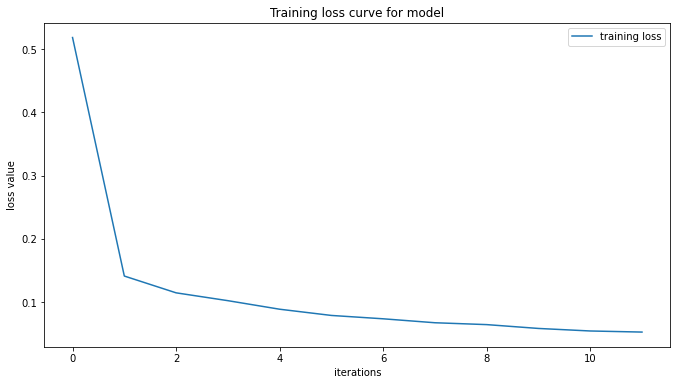

In [ ]:
# Plot the loss curve for the model training
def show_loss(loss_list):
  fig = plt.figure(figsize=(12,6))
  plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
  ax = fig.add_subplot(1,1,1)

  ax.clear()
  ax.set_xlabel('iterations')
  ax.set_ylabel('loss value')
  ax.set_title('Training loss curve for model')
  ax.plot(loss_list, label='training loss')
  ax.legend(loc='upper right')
  fig.canvas.draw()

show_loss(loss_list)

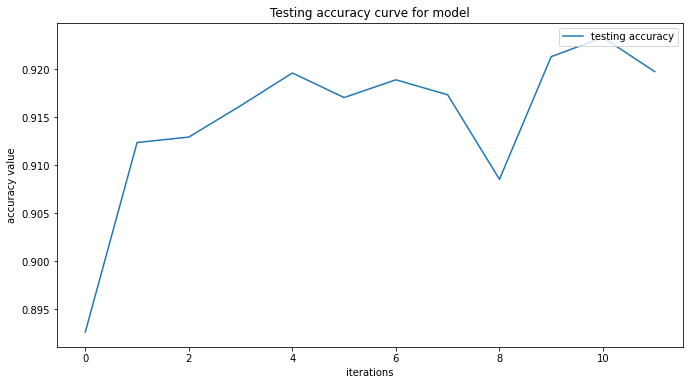

In [ ]:
# Plot the accuracy curve for the model training
def show_accu(accu_list):
  fig = plt.figure(figsize=(12,6))
  plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
  ax = fig.add_subplot(1,1,1)

  ax.clear()
  ax.set_xlabel('iterations')
  ax.set_ylabel('accuracy value')
  ax.set_title('Testing accuracy curve for model')
  ax.plot(accu_list, label='testing accuracy')
  ax.legend(loc='upper right')
  fig.canvas.draw()

show_accu(test_accu)

## **Part 5: Unsupervised training**
In this section, we will use unsupervised training to detect K+N classes and the labels for the newly added N classes are removed.






### **(a). Encoder**<br>
The encoder can extract the features output by the model using include_top = False. Then the decoder will do operations including pca and k means to cluster the K+N classes using those features. 


In [ ]:
# Given a (pre-trained) model, encode the data into its latent space
def encoder(model, data):
  model.eval()
  output = []
  with torch.no_grad():
    for image in data:
      x = image[None,None].type(torch.FloatTensor).to(device)
      output.append(model(x, include_top=False).cpu().numpy())
  output = np.array(output)
  output = np.reshape(output, (output.shape[0], output.shape[2]))
  return output

In [ ]:
trainX_encoded = encoder(model, train_X_orig)
print(trainX_encoded.shape)
trainX2_encoded = encoder(model, train_uX_orig)
print(trainX2_encoded.shape)
untrainedX2_encoded = encoder(untrained_model, train_uX_orig)

(60000, 1936)
(18000, 1936)


### **(b).Decoder**

In [ ]:
class Decoder:

  def get_pca(self, X, n):
    model_pca = PCA(n_components=n)
    output = model_pca.fit_transform(X)
    return output.astype('float32')


  def get_kmeans(self, X, k):
    model_kmeans = KMeans(n_clusters=k, random_state=484)

    start = time.time()
    output = model_kmeans.fit_predict(X)
    end = time.time()

    print("K-Means Algorithm took {} seconds".format(end-start))
    return output

  def get_gmm(self, data, k):
      g = GaussianMixture(n_components=k, covariance_type="full", random_state=728)
      
      start=time.time()
      g.fit(data)
      end=time.time()
      
      print("GMM Algorithm took {} seconds".format(end-start))
      
      return g
      
  def decode(self, data_encoded, pca_components=50, k = len(classes)):
    pca_fit = self.get_pca(data_encoded, n=pca_components)
    kmeans_pred = self.get_kmeans(pca_fit, k)
    # gmm_pred = self.get_gmm(pca_fit, k)
    return kmeans_pred

In [ ]:
decoder = Decoder()
trainX_mpred = decoder.decode(trainX_encoded)
trainX_pred = decoder.decode(trainX_flatten)
trainX2_mpred = decoder.decode(trainX2_encoded)
trainX2_pred = decoder.decode(trainX2_flatten)
untrainedX2_pred = decoder.decode(untrainedX2_encoded)

K-Means Algorithm took 5.476989984512329 seconds
K-Means Algorithm took 6.713917970657349 seconds
K-Means Algorithm took 1.8563604354858398 seconds
K-Means Algorithm took 2.1031887531280518 seconds
K-Means Algorithm took 2.167057752609253 seconds


### **(c). Count clusters and seperate them.**

In [ ]:
def cluster_label_count(clusters, labels):  
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(classes)

    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0

    # Let's count
    for i in range(len(clusters)):
      idx = labels[i].item()
      count[clusters[i]][unique_labels[idx]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [ ]:
trainX_mcluster = cluster_label_count(trainX_mpred, train_y_orig)
trainX_cluster = cluster_label_count(trainX_pred, train_y_orig)

trainX2_mcluster = cluster_label_count(trainX2_mpred, train_uy_orig)
trainX2_cluster = cluster_label_count(trainX2_pred, train_uy_orig)

untrainX2_cluster = cluster_label_count(untrainedX2_pred, train_uy_orig)

In [ ]:
print("Model + KMeans Cluster (full trainset):")
trainX_mcluster

Model + KMeans Cluster (full trainset):


,0,1,2,3,4,5,6,7,8,9
T-shirt/top,1275,0,0,599,0,44,117,3823,138,4
Trouser,234,4936,0,808,4,7,1,9,0,1
Pullover,1276,0,0,22,3,749,3038,23,887,2
Dress,338,1,5,4817,4,718,61,46,8,2
Coat,433,0,1,239,6,2659,314,5,2334,9
Sandal,56,0,3534,9,2397,0,0,0,0,4
Shirt,1784,0,1,307,1,350,787,758,2007,5
Sneaker,11,0,4627,0,1362,0,0,0,0,0
Bag,3027,1,163,87,28,105,13,3,27,2546
Ankle boot,185,0,205,36,5573,0,0,0,1,0


In [ ]:
print("KMeans Cluster (full trainset):")
trainX_cluster

KMeans Cluster (full trainset):


,0,1,2,3,4,5,6,7,8,9
T-shirt/top,0,28,199,167,3405,588,23,0,2,1588
Trouser,0,0,5414,63,236,156,3,0,0,128
Pullover,0,27,9,3520,115,515,28,1,1,1784
Dress,0,7,3206,49,1681,523,5,0,0,529
Coat,0,29,155,3598,872,251,16,0,0,1079
Sandal,480,13,1,0,2,3777,4,258,1435,30
Shirt,0,17,60,1955,1055,772,62,1,6,2072
Sneaker,765,0,0,0,0,515,2,22,4696,0
Bag,65,2436,26,267,22,492,2216,6,237,233
Ankle boot,2987,0,2,1,2,170,4,2621,177,36


In [ ]:
print("Model + KMeans Cluster (unseen trainset):")
trainX2_mcluster

Model + KMeans Cluster (unseen trainset):


,0,1,2,3,4,5,6,7,8,9
T-shirt/top,0,0,0,0,0,0,0,0,0,0
Trouser,0,0,0,0,0,0,0,0,0,0
Pullover,0,0,0,0,0,0,0,0,0,0
Dress,0,0,0,0,0,0,0,0,0,0
Coat,0,0,0,0,0,0,0,0,0,0
Sandal,0,0,0,0,0,0,0,0,0,0
Shirt,551,9,0,1,2107,1225,1356,747,3,1
Sneaker,0,0,0,0,0,0,0,0,0,0
Bag,2,1428,3,1325,26,117,80,3009,0,10
Ankle boot,0,0,1952,0,0,2,3,147,1230,2666


In [ ]:
print("KMeans Cluster (unseen trainset):")
trainX2_cluster

KMeans Cluster (unseen trainset):


,0,1,2,3,4,5,6,7,8,9
T-shirt/top,0,0,0,0,0,0,0,0,0,0
Trouser,0,0,0,0,0,0,0,0,0,0
Pullover,0,0,0,0,0,0,0,0,0,0
Dress,0,0,0,0,0,0,0,0,0,0
Coat,0,0,0,0,0,0,0,0,0,0
Sandal,0,0,0,0,0,0,0,0,0,0
Shirt,0,2338,539,0,1778,1,14,38,8,1284
Sneaker,0,0,0,0,0,0,0,0,0,0
Bag,4,737,361,124,48,2,1356,1991,1340,37
Ankle boot,2235,166,1,1971,0,1618,0,3,0,6


## **Part 6: Validation of Unsupervised training**
In this part, we will do qualitative and quantitative evaluation of predictions.

In [ ]:
# # the seen and unseen class clustering score
# trainX_m_score = homogeneity_score(trainX_mpred, train_y_orig)
# print("2-step (Model+Kmeans) training accuracy on all classes: ", trainX_m_score)
# trainX_score = homogeneity_score(trainX_pred, train_y_orig)
# print("K means accuracy on all classes: ",  trainX_score)

# print("")

# # the unseen class clustering score
# trainX2_m_score = homogeneity_score(trainX2_mpred, train_uy_orig)
# print("2-step (Model+Kmeans) training accuracy on unseen classes: " + str(trainX2_m_score))
# trainX2_score = homogeneity_score(trainX2_pred, train_uy_orig)
# print("K means accuracy on unseen classes: " + str(trainX2_score))
# untrainedX2_score = homogeneity_score(untrainedX2_pred, train_uy_orig)
# print("Untrained accuracy on unseen classes: " + str(untrainedX2_score))

### **(a). Evaluation method for k-means clustering result** <br>

 The following methods that we use are all external critertion that evaluates the performance of clustering compare to the ground truth labels.


1.   Manually assign label to cluster
2.   Purity
3.   Rand Index / Ajusted Rand Index


**Manually assign label to cluster**

> This algorithm works same as how human assign label to cluster. In the first step, it will choose the index $(i,j)$ where element in $(i,j)$ is the max value within $i$th row or $j$th column.

> As each cluster should only be assigned one label, second step deals with the confusing label and cluster pairs. It will traverse all possible combination of the remaining label and cluster pairs. Ans choose the combination that will give max accuracy level.

**Purity**

  Purity measures the number of percentage of the labels that are clustered correctly. 

$$Purity = \frac{1}{N} \sum_{i=1}^{k} max_j|c_i \cap t_j|$$

  

> where $N$ stands for the total number of objects(data) in the dataset, $k$ is the number of clusters and $c_i$ one cluster in $C$ and $t_j$ is the class label. The equation $max_j|c_i \cap t_j|$ represent the class $j$ which has the max count in cluster $c_i$.










**Ajusted Rand Index**

  Rand Index measures the similarity between two clusterings. It also computes the percentage of correct pairs using the following equation.

$$RI = \frac{\text{number of agreeing pairs}}{\text{number of pairs}}$$



> In our evaluation, we will be using the rand index ajusted for chance. Ajusted Rand Index is often used when the ground truth clustering are about the same size which matches our dataset.



In [ ]:
class evaluation:

  def __init__(self, result_matrix):
    self.result_matrix = result_matrix
    self.num_object = np.sum(result_matrix)
    self.class_label = np.argmax(result_matrix, axis = 1) # get the the label 
    self.num_correct_label = np.max(result_matrix, axis = 1) # get number of corrected labeling

  def manual_assign_label_cluster(self):
    row_index = self.result_matrix.argmax(axis=1)
    col_index = self.result_matrix.argmax(axis=0)
    accu_pred = 0

    index_pair = {}
    class_arr = np.array(list(range(0, len(row_index))))

    # Step 1
    for i in range(len(row_index)):
      if(col_index[row_index[i]] == i):
          index_pair[i] = row_index[i]
          accu_pred += self.result_matrix[i][row_index[i]]

    non_match_class = list(set(class_arr) - set(index_pair.keys()))
    non_match_cluster = list(set(class_arr) - set(index_pair.values()))

    sum_accu = 0
    remaining_pair = []

    # Step 2
    if(len(index_pair)<len(row_index)):
      # pair_arr sample: [[(5, 0), (6, 3)], [(6, 0), (5, 3)]]
      pair_arr = [list(zip(x,non_match_cluster)) for x in itertools.permutations(non_match_class,len(non_match_cluster))]
      for pair in pair_arr:
        accu = 0
        for index_tuple in pair:
          accu += self.result_matrix[index_tuple[0]][index_tuple[1]]
        if accu >= sum_accu:
          sum_accu = accu
          remaining_pair = pair

    accu_pred += sum_accu
    for t in remaining_pair:
      index_pair[t[0]] = t[1]

    return accu_pred/np.sum(self.result_matrix), index_pair


  def eval_purity(self):
    total_correct_label = np.sum(self.num_correct_label)
    num_object = self.num_object
    return total_correct_label / self.num_object
  

  def eval_ajusted_rand_index(self, gt, predict):
    return adjusted_rand_score(gt, predict)



In [ ]:
eval = evaluation(trainX_cluster.to_numpy())
accu_kmean, pair_list_kmean = eval.manual_assign_label_cluster()
label_cluster_kpair = {}
for key in pair_list_kmean:
  label_cluster_kpair[classes[key]] = pair_list_kmean[key]

print("Only using Kmean (without model) result is:")
print(trainX_cluster)
print("\nThe assigned label and cluster pair is:")
print(label_cluster_kpair)
print("\nAccuracy Checking by assigning labels to clusters is: ", accu_kmean)

Only using Kmean (without model) result is:
                0     1     2     3     4     5     6     7     8     9
T-shirt/top     0    28   199   167  3405   588    23     0     2  1588
Trouser         0     0  5414    63   236   156     3     0     0   128
Pullover        0    27     9  3520   115   515    28     1     1  1784
Dress           0     7  3206    49  1681   523     5     0     0   529
Coat            0    29   155  3598   872   251    16     0     0  1079
Sandal        480    13     1     0     2  3777     4   258  1435    30
Shirt           0    17    60  1955  1055   772    62     1     6  2072
Sneaker       765     0     0     0     0   515     2    22  4696     0
Bag            65  2436    26   267    22   492  2216     6   237   233
Ankle boot   2987     0     2     1     2   170     4  2621   177    36

The assigned label and cluster pair is:
{'T-shirt/top': 4, 'Trouser': 2, 'Coat': 3, 'Sandal': 5, 'Shirt': 9, 'Sneaker': 8, 'Bag': 1, 'Ankle boot': 0, 'Pullover': 6

In [ ]:
trainX_matrix = trainX_cluster.to_numpy()
eval_k = evaluation(trainX_matrix)
print("Only using Kmean (without model) result is:")

# evaluate purity
purity = eval_k.eval_purity()
print("Purity is  " + str(purity))

# evaluate rand index (Ajusted)
ajusted_rand_index = eval_k.eval_ajusted_rand_index(trainX_pred, train_y_orig)
print("Ajusted rand index is " + str(ajusted_rand_index))

Only using Kmean (without model) result is:
Purity is  0.5851833333333334
Ajusted rand index is 0.34784809078557893


In [ ]:
eval_ck = evaluation(trainX_mcluster.to_numpy())
accu, pair_list = eval_ck.manual_assign_label_cluster()

label_cluster_pair = {}
for key in pair_list:
  label_cluster_pair[classes[key]] = pair_list[key]

print("Model + Kmean clustering result is:")
print(trainX_mcluster)
print("\nThe assigned label and cluster pair is:")
print(label_cluster_pair)
print("\nAccuracy Checking by assigning labels to clusters is: ", accu)

Model + Kmean clustering result is:
                0     1     2     3     4     5     6     7     8     9
T-shirt/top  1275     0     0   599     0    44   117  3823   138     4
Trouser       234  4936     0   808     4     7     1     9     0     1
Pullover     1276     0     0    22     3   749  3038    23   887     2
Dress         338     1     5  4817     4   718    61    46     8     2
Coat          433     0     1   239     6  2659   314     5  2334     9
Sandal         56     0  3534     9  2397     0     0     0     0     4
Shirt        1784     0     1   307     1   350   787   758  2007     5
Sneaker        11     0  4627     0  1362     0     0     0     0     0
Bag          3027     1   163    87    28   105    13     3    27  2546
Ankle boot    185     0   205    36  5573     0     0     0     1     0

The assigned label and cluster pair is:
{'T-shirt/top': 7, 'Trouser': 1, 'Pullover': 6, 'Dress': 3, 'Coat': 5, 'Sneaker': 2, 'Bag': 0, 'Ankle boot': 4, 'Shirt': 8, 'Sandal

In [ ]:
trainX_cluster_matrix = trainX_mcluster.to_numpy()
eval = evaluation(trainX_cluster_matrix)
print("Model + Kmean clustering result is:")

# evaluate purity
purity = eval.eval_purity()
print("Purity is  " + str(purity))

# evaluate rand index (Ajusted)
ajusted_rand_index = eval.eval_ajusted_rand_index(trainX_mpred, train_y_orig)
print("Ajusted rand index is " + str(ajusted_rand_index))

Model + Kmean clustering result is:
Purity is  0.6340166666666667
Ajusted rand index is 0.42975900821282437


**(aa) Summery of different dataset**

In [ ]:
print("===========================================================")
# trainX_mcluster = cluster_label_count(trainX_mpred, train_y_orig)
eval = evaluation(trainX_mcluster.to_numpy())
accu, pair_list = eval.manual_assign_label_cluster()
purity = eval.eval_purity()
ajusted_rand_index = eval.eval_ajusted_rand_index(trainX_mpred, train_y_orig)
print("Evaluation for data with trained model + Kmean clustering (Seen label):")
print("Manural Assign Label accu: ", accu)
print("Purity: ", purity)
print("Adjust Random Index: ", ajusted_rand_index)
print("===========================================================")

# trainX_cluster = cluster_label_count(trainX_pred, train_y_orig)
eval = evaluation(trainX_cluster.to_numpy())
accu, pair_list = eval.manual_assign_label_cluster()
purity = eval.eval_purity()
ajusted_rand_index = eval.eval_ajusted_rand_index(trainX_pred, train_y_orig)
print("Evaluation for data with only Kmean clustering (Seen label):")
print("Manural Assign Label accu: ", accu)
print("Purity: ", purity)
print("Adjust Random Index: ", ajusted_rand_index)
print("===========================================================")

# trainX2_mcluster = cluster_label_count(trainX2_mpred, train_uy_orig)
eval = evaluation(trainX2_mcluster.to_numpy())
accu, pair_list = eval.manual_assign_label_cluster()
purity = eval.eval_purity()
ajusted_rand_index = eval.eval_ajusted_rand_index(trainX2_mpred, train_uy_orig)
print("Evaluation for data with trained model + Kmean clustering (Unseen label):")
print("Manural Assign Label accu: ", accu)
print("Purity: ", purity)
print("Adjust Random Index: ", ajusted_rand_index)
print("===========================================================")

# trainX2_cluster = cluster_label_count(trainX2_pred, train_uy_orig)
eval = evaluation(trainX2_cluster.to_numpy())
accu, pair_list = eval.manual_assign_label_cluster()
purity = eval.eval_purity()
ajusted_rand_index = eval.eval_ajusted_rand_index(trainX2_pred, train_uy_orig)
print("Evaluation for data with only Kmean clustering (Unseen label):")
print("Manural Assign Label accu: ", accu)
print("Purity: ", purity)
print("Adjust Random Index: ", ajusted_rand_index)
print("===========================================================")

# untrainX2_cluster = cluster_label_count(untrainedX2_pred, train_uy_orig)
eval = evaluation(untrainX2_cluster.to_numpy())
accu, pair_list = eval.manual_assign_label_cluster()
purity = eval.eval_purity()
ajusted_rand_index = eval.eval_ajusted_rand_index(untrainedX2_pred, train_uy_orig)
print("Evaluation for data with Untrained model + Kmean clustering (Unseen label):")
print("Manural Assign Label accu: ", accu)
print("Purity: ", purity)
print("Adjust Random Index: ", ajusted_rand_index)
print("===========================================================")


Evaluation for data with trained model + Kmean clustering (Seen label):
Manural Assign Label accu:  0.5751833333333334
Purity:  0.6340166666666667
Adjust Random Index:  0.42975900821282437
Evaluation for data with only Kmean clustering (Seen label):
Manural Assign Label accu:  0.47355
Purity:  0.5851833333333334
Adjust Random Index:  0.34784809078557893
Evaluation for data with trained model + Kmean clustering (Unseen label):
Manural Assign Label accu:  0.43233333333333335
Purity:  0.43233333333333335
Adjust Random Index:  0.3380160774504377
Evaluation for data with only Kmean clustering (Unseen label):
Manural Assign Label accu:  0.36466666666666664
Purity:  0.36466666666666664
Adjust Random Index:  0.3046033652476269
Evaluation for data with Untrained model + Kmean clustering (Unseen label):
Manural Assign Label accu:  0.37405555555555553
Purity:  0.37405555555555553
Adjust Random Index:  0.2987337990177589


Summary: We could see that comparing the first two, we get around 7-10% improvement for each accuracy if we use 2-step method (trained model + Kmean). Comparing 3rd and 4th result, we could see that for unseen class only, the improvement is also around 7-10%. Comparing 3rd and 5th, we coud see that the accuracy of 2-step (unseen class) using trained model is better than fully untrained model, which means our training do have improvement for unseen classes.

### **(b). Evaluate results based on the pca values**

This part will do the above evaluations, but the pca value will change.

In [ ]:
def evaluation_results(model, data, data_y, pca_val):
  encode_data = encoder(model, data)
  # initialize decoder
  decoder = Decoder()
  data_pred = decoder.decode(encode_data, pca_val)
  cluster = cluster_label_count(data_pred, data_y)

  # initial evaluation class
  eval = evaluation(cluster.to_numpy())  
  # manual assign label to clusters
  accu, pair_list = eval.manual_assign_label_cluster()
  # purity
  purity = eval.eval_purity()
  # adjust rand index
  adjusted_rand_index = eval.eval_ajusted_rand_index(data_pred, data_y)

  return accu, purity, adjusted_rand_index

In [ ]:
manutal_accu_list = []
purity_list = []
adj_list = []

for i in range(20):
  accu, purity, adjusted_rand_index = evaluation_results(model, train_uX_orig, train_uy_orig, (i+1)*80)
  manutal_accu_list.append(accu)
  purity_list.append(purity)
  adj_list.append(adjusted_rand_index)


K-Means Algorithm took 2.784895181655884 seconds
K-Means Algorithm took 3.8392441272735596 seconds
K-Means Algorithm took 6.450971364974976 seconds
K-Means Algorithm took 7.341244697570801 seconds
K-Means Algorithm took 9.699296474456787 seconds
K-Means Algorithm took 10.237628936767578 seconds
K-Means Algorithm took 14.3947434425354 seconds
K-Means Algorithm took 13.218460321426392 seconds
K-Means Algorithm took 15.07935118675232 seconds
K-Means Algorithm took 19.03579568862915 seconds
K-Means Algorithm took 17.371228456497192 seconds
K-Means Algorithm took 19.379465103149414 seconds
K-Means Algorithm took 21.578354120254517 seconds
K-Means Algorithm took 23.47306752204895 seconds
K-Means Algorithm took 24.857829809188843 seconds
K-Means Algorithm took 26.757277250289917 seconds
K-Means Algorithm took 27.88071632385254 seconds
K-Means Algorithm took 29.075495958328247 seconds
K-Means Algorithm took 33.673166275024414 seconds
K-Means Algorithm took 30.668623447418213 seconds


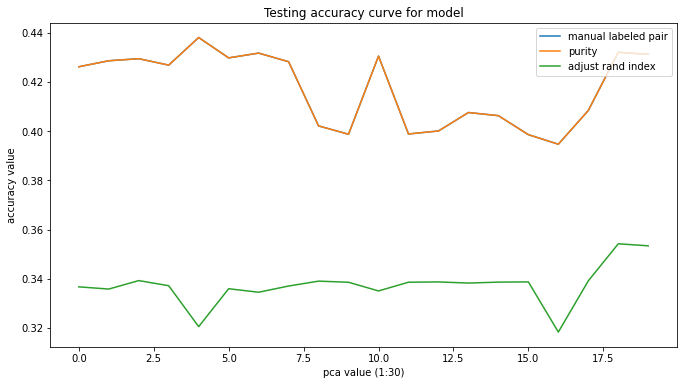

In [ ]:
# Plot the accuracy curve for the model training
def show_accu(accu_list, purity_list, adj_list):
  fig = plt.figure(figsize=(12,6))
  plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
  ax = fig.add_subplot(1,1,1)

  ax.clear()
  ax.set_xlabel('pca value (1:30)')
  ax.set_ylabel('accuracy value')
  ax.set_title('Testing accuracy curve for model')
  ax.plot(accu_list, label='manual labeled pair')
  ax.plot(purity_list, label='purity')
  ax.plot(adj_list, label='adjust rand index')
  ax.legend(loc='upper right')
  fig.canvas.draw()

show_accu(manutal_accu_list,purity_list,adj_list)

Summary: This plot does not show strong relationship between PCA values and prediction accuracy in our model.

## **Part 7: Conclusion - Limitation & Future Improvement**
The result produced by our 2-step method has shown around 7% improvement in the prediction accuracy for the unseen N class compare to the pure k-means clustering method. It also has shown around 10% improvement in the prediction accuracy for K+N (K seen, N unseen) class compare to the pure k-means clustering method. This is a moderate increase and there are room for improvement.

One of the possible improvement is the design of the supervised network. Given our loss value 0.05, which is already very small, we achieve around 10% improvement in prediction accuracy. This implies that the loss function need to be improved for better indication of model accuracy and the network itself may require some redesign. Another limitations we have is the choice of the clustering method. Some other clustering method might be more appropriate to use. However, those methods might be complicated and so it is difficult to implement and we choose K-means instead. 

<!-- If the loss could be closer to 0, the network is likely to differentiate the K classes better given what it learned so far. The features we use to perform K-means might produce higher accuracy than the current one. We could achieve this by modifying our loss function or design a better network. -->



There are also external limitations other than the design itself. One limitation of the work would be that the limited power of computation. If given a better computational resource, we would be able to train more complicated models and possibly obtain higher accuracy. 

### **Reference - Related Resources**

Evaluation of clustering. (n.d.). Stanford University. Retrieved December 20, 2021, from https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html 

Doersch, C., Gupta, A., Efros, A. A. (2016, January 16). Unsupervised visual representation learning by context prediction. arXiv.org. Retrieved December 20, 2021, from https://arxiv.org/abs/1505.05192

